# Load libraries

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
import os
import pandas as pd
import requests
from io import BytesIO
import random
import numpy as np
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import v2, functional
from torchvision import transforms
from sklearn.model_selection import train_test_split




# Define helper functions/classes

In [2]:
## convert RGB to the personal LAB (LAB2)
# the input R,G,B,  must be 1D from 0 to 255
# the outputs are 1D  L [0 1], a [-1 1] b [-1 1]
def RGB2LAB2(R0, G0, B0):

    R=R0/255
    G=G0/255
    B=B0/255

    # Y=0.3*R + 0.59*G + 0.11*B
    # X=0.45*R + 0.35*G + 0.2*B
    # Z=0.01*R + 0.09*G + 0.9*B

    Y=0.299*R + 0.587*G + 0.114*B
    X=0.449*R + 0.353*G + 0.198*B
    Z=0.012*R + 0.089*G + 0.899*B

    # X - Y = 0.150*R - 0.234*G + 0.084*B  = a0
    # Y - Z = 0.287*R + 0.498*G - 0.785*B  = b0

    L = Y
    a = (X - Y)/0.234
    b = (Y - Z)/0.785

    return L, a, b

## convert the personal LAB (LAB2)to the RGB
# the input L,a,b,  must be 1D L [0 1], a [-1 1] b [-1 1]
# the outputs are 1D  R g B [0 255]
def LAB22RGB(L, a, b):

    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa=np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0=np.zeros((L.shape[0],3))
    C0[:,0]=L[:,0]
    C0[:,1]=a[:,0]
    C0[:,2]=b[:,0]
    C = np.transpose(C0)
    # C = np.array([L, a, b])
    # print(C.shape)
    # print(L.shape)
    # print(a.shape)
    # print(b.shape)
    # print(aa.shape)

    X = np.linalg.inv(aa).dot(C)
    X1D=np.reshape(X,(X.shape[0]*X.shape[1],1))
    p0=np.where(X1D<0)
    X1D[p0[0]]=0
    p1=np.where(X1D>1)
    X1D[p1[0]]=1
    Xr=np.reshape(X1D,(X.shape[0],X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint(np.round(Rr*255))
    G = np.uint(np.round(Gr*255))
    B = np.uint(np.round(Br*255))
    # p0=np.where(L<0.02)
    # R[p0[0]]=0
    # G[p0[0]]=0
    # B[p0[0]]=0
    # p1=np.where(L>0.98)
    # R[p1[0]]=255
    # G[p1[0]]=255
    # B[p1[0]]=255
    return R, G, B

# def convert_to_feed_model_func(RGB_image):

#     sz0=RGB_image.shape[0]
#     sz1=RGB_image.shape[1]

#     train_imgs=np.zeros((sz0,sz1,2))
#     train_input=np.zeros((sz0,sz1,1))

#     ab=np.zeros((sz0,sz1,2))
#     R1 = np.reshape(RGB_image[:,:,0],(sz0*sz1,1))
#     G1 = np.reshape(RGB_image[:,:,1],(sz0*sz1,1))
#     B1 = np.reshape(RGB_image[:,:,2],(sz0*sz1,1))
#     L, A, B = RGB2LAB2(R1,G1,B1)
#     A = np.reshape(A,(sz0,sz1))
#     B = np.reshape(B,(sz0,sz1))
#     ab[:,:,0] = A
#     ab[:,:,1] = B
#     train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
#     train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))

#     return (train_input, train_imgs)


In [3]:
def plot_transform(orig_img, imgs, with_orig=True, row_title=None, img_size = 10, **imshow_kwargs):

    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize = (img_size, img_size))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Define custom Dataset class


In [4]:
# the idea was borrowed from here: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

class Swisstopodataset(Dataset):
    def __init__(self, img_indx, transform = None, large_dataset=False, return_label = True):
        self.img_indx = img_indx
        self.transform = transform
        self.large_dataset = large_dataset
        self.return_label = return_label
        # self.augment = augment

    def __len__(self):
        return len(self.img_indx)

    def __getitem__(self, idx):
        # img_filepath  = self.img_indx[idx]
        if self.large_dataset:
            port = 1986
        else:
            port = 1985
        raw_data_csv_file_link = f"https://perritos.myasustor.com:{port}/metadata.csv"
        metadata_file = pd.read_csv(raw_data_csv_file_link, index_col=0)
        img_in_server_link = f"https://perritos.myasustor.com:{port}/data/img_id_{self.img_indx[idx]}.jpg"
        response = requests.get(img_in_server_link)
        image = Image.open(BytesIO(response.content))
        # image = cv2.imread(img_filepath)
        # image = Image.fromarray(image)

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # define here a label if existing
        label = metadata_file["class"].iloc[idx]

        if self.transform is not None:
            # print ("*** Transforming RGB img to LAB ***")
            image = self.transform(image)

        # if self.augment is not None:
        #     # print ("*** Applying augmentation on L channel ***")
        #     image_L, imageAB = image
        #     image_L = self.augment(image_L)
        #     image = (image_L, imageAB)


        if self.return_label:
            return image, label
        else:
            return image


# Define transforms


In [5]:
# class convert_RGB_to_feed_model(torch.nn.Module):
#     def forward(self, img):
#         img = np.asanyarray(img)
#         sz0=img.shape[0]
#         sz1=img.shape[1]

#         train_imgs=np.zeros((sz0,sz1,2))
#         train_input=np.zeros((sz0,sz1,1))

#         ab=np.zeros((sz0,sz1,2))
#         R1 = np.reshape(img[:,:,0],(sz0*sz1,1))
#         G1 = np.reshape(img[:,:,1],(sz0*sz1,1))
#         B1 = np.reshape(img[:,:,2],(sz0*sz1,1))
#         L, A, B = RGB2LAB2(R1,G1,B1)
#         A = np.reshape(A,(sz0,sz1))
#         B = np.reshape(B,(sz0,sz1))
#         ab[:,:,0] = A
#         ab[:,:,1] = B
#         train_input[:,:,:] =  np.reshape(L,(1,sz0,sz1,1))
#         train_imgs[:,:,:] = np.reshape(ab,(1,sz0,sz1,2))
#         return (train_input, train_imgs)

class convert_RGB_to_feed_model(torch.nn.Module):
    def forward(self, img):
        img = np.asanyarray(img)
        sz_x=img.shape[0]
        sz_y=img.shape[1]

        train_imgs=np.zeros((sz_x,sz_y,2))
        train_input=np.zeros((sz_x,sz_y,1))

        ab=np.zeros((sz_x,sz_y,2))
        R1 = np.reshape(img[:,:,0],(sz_x*sz_y,1))
        G1 = np.reshape(img[:,:,1],(sz_x*sz_y,1))
        B1 = np.reshape(img[:,:,2],(sz_x*sz_y,1))
        L, A, B = RGB2LAB2(R1,G1,B1)
        # A = np.reshape(A,(sz_x,sz_y))
        # B = np.reshape(B,(sz_x,sz_y))
        # ab[:,:,0] = A
        # ab[:,:,1] = B
        # print(f"shape of ab is: {ab.shape}")
        # print(f"shape of L is: {L.shape}")
        # train_input[:,:,:] =  np.reshape(L,(1,sz_x,sz_y,1))
        # train_imgs[:,:,:] = np.reshape(ab,(1,sz_x,sz_y,2))

        train_input[:,:,0] = L.reshape((sz_x,sz_y))
        train_imgs[:,:,0] = np.reshape(A,(sz_x,sz_y))
        train_imgs[:,:,1] = np.reshape(B,(sz_x,sz_y))

        # print(f"shape of train_input is: {train_input.shape}")
        # print(f"shape of train_imgs is: {train_imgs.shape}")

        return (train_input, train_imgs)

In [6]:
# NOTE: need to crate a transform class to revert from model to RGB, so the oposite from the class convert_RGB_to_feed_model
class convert_from_LAB_to_RGB(torch.nn.Module):
    def forward(self, img_raw):
        image, _ = img_raw
        print(image.shape)
        # sz0 = image.shape[0]
        # sz1 = image.shape[1]
        # sz2 = image.shape[2]
        # LAB_img = np.reshape(LAB_img,(sz0*sz1,bands))
        # Ar = LAB_img[:,0:1]
        # Br = LAB_img[:,1:2]

        # Rr, Gr, Br = LAB22RGB(L,Ar,Br)
        # Rr = np.reshape(Rr,(sz0,sz1))
        # Gr = np.reshape(Gr,(sz0,sz1))
        # Br = np.reshape(Br,(sz0,sz1))
        # predicted255=np.uint8(np.zeros((sz0,sz1,3)))
        # predicted255[:,:,0] = Rr
        # predicted255[:,:,1] = Gr
        # predicted255[:,:,2] = Br
        # return (predicted255)

In [15]:
class LTransformation(object):
    def __init__(self, contrast_range=(0.8, 1.2), brightness_range=(-0.25, 0.25)):
        self.contrast_range = contrast_range
        self.brightness_range = brightness_range

    def _apply_factor(self, lab_image, contrast_factor, brightness_factor):
        # Apply adjusted brightness and contrast to the L channel
        L_adjusted = contrast_factor * lab_image[:,:,0] + brightness_factor

        # Merge LAB channels back together
        lab_image_adjusted = np.stack([np.clip(L_adjusted, 0, 1), lab_image[:,:,1], lab_image[:,:,2]], axis=-1)

        return lab_image_adjusted

    def _randomize_factors(self):
        return np.random.uniform(*self.brightness_range), np.random.uniform(*self.contrast_range)

    def __call__(self, lab_image):
        while True:
            brightness_factor, contrast_factor = self._randomize_factors()

            # Apply adjusted brightness and contrast to the L channel
            lab_image_adjusted = self._apply_factor(lab_image, contrast_factor, brightness_factor)

            # Check if values are within range
            max_val = np.max(lab_image_adjusted[:,:,0])
            min_val = np.min(lab_image_adjusted[:,:,0])

            if 0 <= min_val <= 1 and 0 <= max_val <= 1:
                break

        return lab_image_adjusted, contrast_factor, brightness_factor

In [8]:
class convert_RGB_and_LTransform_to_feed_model(torch.nn.Module):
    def forward(self, img):
        img = np.asanyarray(img)
        sz_x = img.shape[0]
        sz_y = img.shape[1]

        train_imgs = np.zeros((sz_x, sz_y, 2))
        train_input = np.zeros((sz_x, sz_y, 1))
        ab=np.zeros((sz_x,sz_y,2))

        R1 = np.reshape(img[:,:,0], (sz_x*sz_y, 1))
        G1 = np.reshape(img[:,:,1], (sz_x*sz_y, 1))
        B1 = np.reshape(img[:,:,2], (sz_x*sz_y, 1))
        L, A, B = RGB2LAB2(R1, G1, B1)

        # Apply LTransformation to the L channel
        L_adjusted, _, _ = LTransformation()(L.reshape((sz_x, sz_y)))

        train_input[:,:,0] = L_adjusted
        train_imgs[:,:,0] = np.reshape(A, (sz_x, sz_y))
        train_imgs[:,:,1] = np.reshape(B, (sz_x, sz_y))

        return train_input, train_imgs

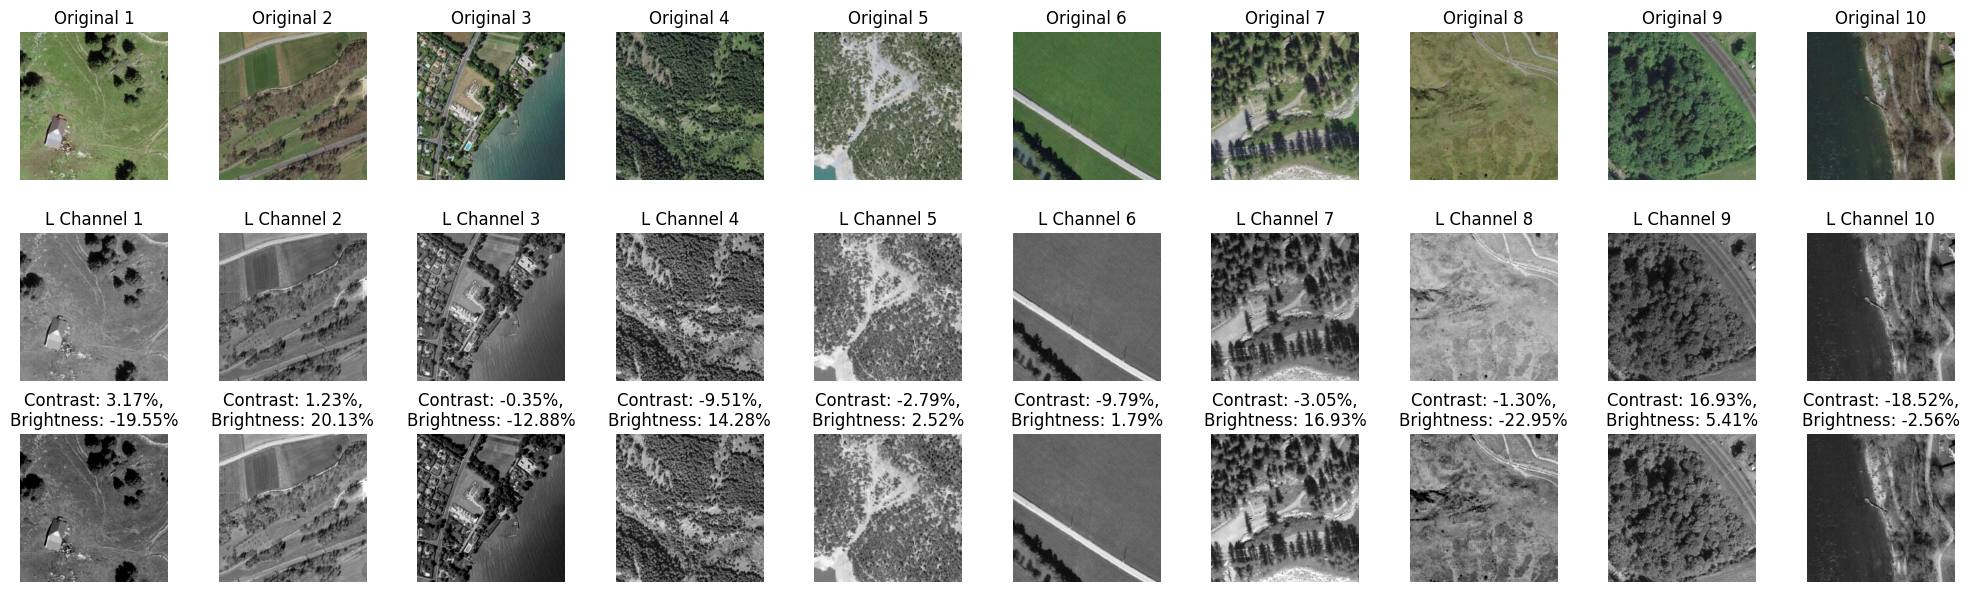

In [16]:
def plot_lab_transformation(num_images=10):
    # Retrieve and visualize random sample images
    fig, axes = plt.subplots(3, num_images, figsize=(20, 6))
    for test_index_img in range(num_images):
        random_index = random.randint(0, 999)
        url = f"https://perritos.myasustor.com:1985/data/img_id_{random_index}.jpg"
        response = requests.get(url)
        img_test = Image.open(BytesIO(response.content))
        rgb_img = np.array(img_test)

        # Convert RGB image to LAB
        R = rgb_img[:,:,0]
        G = rgb_img[:,:,1]
        B = rgb_img[:,:,2]
        L, _, _ = RGB2LAB2(R, G, B)

        # Plot the original RGB image
        axes[0, test_index_img].imshow(rgb_img)
        axes[0, test_index_img].axis('off')
        axes[0, test_index_img].set_title(f"Original {test_index_img+1}")

        # Plot the L channel of the LAB image
        axes[1, test_index_img].imshow(L, cmap='gray')
        axes[1, test_index_img].axis('off')
        axes[1, test_index_img].set_title(f"L Channel {test_index_img+1}")

        # Apply LTransformation to the L channel
        lab_image_adjusted, contrast_factor, brightness_factor = LTransformation()(np.stack([L, _, _], axis=-1))

        # Plot the transformed L channel with applied contrast and brightness values
        axes[2, test_index_img].imshow(lab_image_adjusted[:,:,0], cmap='gray')
        axes[2, test_index_img].axis('off')
        brightness_percentage = brightness_factor * 100
        contrast_percentage = (contrast_factor - 1) * 100
        axes[2, test_index_img].set_title(f"Contrast: {contrast_percentage:.2f}%,\nBrightness: {brightness_percentage:.2f}%")

    plt.tight_layout()
    plt.show()

# Call the function to plot random original RGB images, their L channels, and transformed L channels
plot_lab_transformation(num_images=10)

# Check info from the images

The data was initially created using the scripts `retrieve_data.ipynb` and stored in a private server for later (re)use.
In the metadata.csv file we get the information on original link, class and coordinates of each image.

NOTE: the following are links stored in a private server, jet they are still publically available.

In [10]:
is_large_dataset = True

if is_large_dataset:
    server_port = 1986 # Large dataset of ~10K images
else:
    server_port = 1985 # Large dataset of ~10K images
# server_port = 1985 # initial dataset of 3.6K images

raw_data_csv_file_link = f"https://perritos.myasustor.com:{server_port}/metadata.csv"


metadata_raw_df = pd.read_csv(raw_data_csv_file_link, index_col=0)
metadata_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10008 entries, 0 to 10007
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   img_id      10008 non-null  int64  
 1   img_name    10008 non-null  object 
 2   latitude    10008 non-null  float64
 3   longitude   10008 non-null  float64
 4   zoom_level  10008 non-null  int64  
 5   class       10008 non-null  int64  
 6   link        10008 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 625.5+ KB


# Split the Train, Valid and Test subsets.

We use the column `image_id` from the metadata as index of the images and then we perform standard shufling and splitting.

The final ratio for the train, validation and test dastasets are: 70, 29 and 1 % respectively

In [11]:
dataX, dataY = metadata_raw_df["img_id"].to_list(), metadata_raw_df["class"] .to_list()

rand_state = 9898
train_ratio = 0.70
validation_ratio = 0.29
test_ratio = 0.01



# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio, stratify = dataY, random_state=rand_state)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test, random_state=rand_state)

print(f"the size fo the train dataset is: {len(x_train)}.\nthe size fo the validation dataset is: {len(x_val)}.\nthe size fo the test dataset is: {len(x_test)}.")

the size fo the train dataset is: 7005.
the size fo the validation dataset is: 2902.
the size fo the test dataset is: 101.


In [12]:
# This transformation will only change the image colorspace from RGB->LAB
RGBtoLAB_transforms = transforms.Compose(
    [
        # v2.ToImage(), # convert to tensor if you have a PIL image. NOTE: when you do this it convert the image automatically to RGB!!! Be carefull!
        convert_RGB_to_feed_model(),
    ]
)

# This transformation will change the image colorspace from RGB->LAB and apply Transformations on L
RGBtoLAB_LTransform = transforms.Compose(
    [
        # v2.ToImage(), # convert to tensor if you have a PIL image. NOTE: when you do this it convert the image automatically to RGB!!! Be carefull!
        convert_RGB_and_LTransform_to_feed_model(),
    ]
)


In [13]:
train_dataset = Swisstopodataset(x_train,
                                 large_dataset=is_large_dataset,
                                 return_label=False,
                                 transform=RGBtoLAB_LTransform)

valid_dataset= Swisstopodataset(x_val,
                                 large_dataset=is_large_dataset,
                                 return_label=False,
                                 transform=RGBtoLAB_LTransform)

test_dataset= Swisstopodataset(x_test,
                                 large_dataset=is_large_dataset,
                                 return_label=False,
                                 transform=RGBtoLAB_transforms) # NOTE: in the test dataset we dont apply any transformation, just transform to LAB.

print([f"the size of the dataset '{name}' is: {len(i)}" for i, name in zip([train_dataset,
                                                                            valid_dataset,
                                                                            test_dataset],
                                                                            ["train_dataset",
                                                                             "valid_dataset",
                                                                             "test_dataset"])])

["the size of the dataset 'train_dataset' is: 7005", "the size of the dataset 'valid_dataset' is: 2902", "the size of the dataset 'test_dataset' is: 101"]


Dig in an example to check the sahep of the content

In [14]:
for img in test_dataset:
    print(f"object of type: {type(img)}. len of object: {len(img)}")
    print(f"the first element of the object is of type: {type(img[0])} of shape: {img[0].shape}")
    print(f"the second element of the object is of type: {type(img[1])} of shape: {img[1].shape}")
    break

object of type: <class 'tuple'>. len of object: 2
the first element of the object is of type: <class 'numpy.ndarray'> of shape: (256, 256, 1)
the second element of the object is of type: <class 'numpy.ndarray'> of shape: (256, 256, 2)
